In [1]:
#pip install tensorflow==2.9.2

In [1]:
import pandas as pd
import numpy as np
import re
import jieba
import matplotlib.pyplot as plt
from opencc import OpenCC

In [33]:
df = pd.read_excel('../data/sentiment_analysis_latest.xlsx')

In [34]:
df['sentiment_label'].value_counts()

neutral     3267
negative    1943
positive     959
Name: sentiment_label, dtype: int64

In [35]:
replace_tag = {'positive':2, 'neutral':1, 'negative':0}
df['sentiment_label']= df['sentiment_label'].replace(replace_tag)

In [36]:
df_msg = df.copy()

# 1. tokenization

In [37]:
import jieba
from pycantonese.word_segmentation import Segmenter
import pycantonese

In [38]:
# load self-defined tokenization dictionary
jieba.set_dictionary('../data/tokenization_dict/dict.txt')
jieba.load_userdict('../data/tokenization_dict/hk_dict.txt')

Building prefix dict from C:\Users\Harrison\Documents\HKU\paper\GPT_sentiment_analysis\supplementary_material\data\tokenization_dict\dict.txt ...
Loading model from cache C:\Users\Harrison\AppData\Local\Temp\jieba.uca32d7fd4479c948cd6f929a868b2453.cache
Loading model cost 0.665 seconds.
Prefix dict has been built successfully.


In [39]:
s2hk=[]
converter = OpenCC('s2hk.json')
for i in range(len(df_msg)):
    s2hk.append(converter.convert(df_msg.msg_replace[i]))
df_msg['msg_replace']=s2hk

In [40]:
# stopwords
stop_words=['乜','個','嗰','吖','啦','又','呀','咗','咁','呢','咩','哦','哩','啲','啊','喎','嗯','噢','喔',
            '果','係','左','先','架','㗎','噶','嘎','嘅','既','嘢','噉','即','同','都','有','冇','的','黎','嚟',
            '啦', '啵', '喺', '嗱', '嘅', '噃', '咁', '噉', '噓', '唔', '嘛', '咩', '嘢', '啊', '嗚', '嘻', '啫',
            '啱', '添', '喇', '甘', '咯', '啊']

cn_stopwords=list(pd.read_csv("../data/stopwords/cn_stopwords.txt").to_numpy().squeeze())
scu_stopwords=list(pd.read_csv("../data/stopwords/scu_stopwords.txt").to_numpy().squeeze())
traditional_cn_stopwords = []
traditional_scu_stopwords = []
converter = OpenCC('s2hk.json')
for i in range(len(cn_stopwords)):
    traditional_cn_stopwords.append(converter.convert(cn_stopwords[i]))
for i in range(len(scu_stopwords)):
    traditional_scu_stopwords.append(converter.convert(scu_stopwords[i]))
    
pycantonese_stopwords=list(pycantonese.stop_words())

stop_words_total = stop_words + traditional_cn_stopwords + traditional_scu_stopwords + pycantonese_stopwords

In [41]:
# tokenization
speech_list = list(df_msg['msg_replace'])
rule = re.compile(r"[^\u4e00-\u9fa5]")
speech_list = [list(jieba.cut(rule.sub('', speech))) for speech in speech_list]

In [42]:
df_msg['msg_token'] = speech_list

In [ ]:
# remove stopwords
for idx, speech in enumerate(speech_list):
    speech_list[idx] = ' '.join([word for word in speech if word.strip() not in stop_words_total])

df_msg['msg_token'] = speech_list

In [ ]:
df_msg['msg_token'] = [i.split(' ') for i in df_msg['msg_token']]

# 2. construct embedding layer with word2vec

In [43]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout
from keras.optimizers import Adam
from gensim.models import Word2Vec

In [44]:
MAX_NB_WORDS = 4096
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 100

df_msg['msg_token'] = df_msg['msg_token'].fillna("")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_msg['msg_token'].values)
word_index = tokenizer.word_index
print('There are totally %s different tokens.' % len(word_index))

There are totally 9418 different tokens.


In [45]:
w2v_model = Word2Vec.load('../word2vec_embedding/openup_word2vec_20231001.model')

In [46]:
# construct embedding layer
embedding_matrix = np.zeros((len(word_index) + 1, 100))

for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
    else:
        # use a random vector if the word is not in vocabulary
        embedding_matrix[i] = np.random.rand(1, 100)  

In [47]:
# vectorization
X = tokenizer.texts_to_sequences(df_msg['msg_token'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
Y = pd.get_dummies(df['sentiment_label']).values

print(X.shape)
print(Y.shape)

(6169, 300)
(6169, 3)


In [48]:
X

array([[   0,    0,    0, ...,  116,   27,  114],
       [   0,    0,    0, ...,  180,   55,   27],
       [   0,    0,    0, ...,   14,    7,  957],
       ...,
       [   0,    0,    0, ...,   54,   55,   21],
       [   0,    0,    0, ...,    0,    0, 1170],
       [   0,    0,    0, ...,  280,   65,   21]])

In [49]:
# split training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4935, 300) (4935, 3)
(1234, 300) (1234, 3)


# 3. LSTM model

## diagnostic run

In [50]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [51]:
# word2vec as word embedding weights
from keras.layers import Embedding

embedding_layer = Embedding(input_dim=len(word_index) + 1,
                            output_dim=100,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [52]:
def fit_model(X_train, Y_train, learning_rate, dropout_rate, batch_size, epochs=10):
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(100, dropout=dropout_rate))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)
    
    return model, history

In [83]:
model.summary()

Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 100)          941900    
                                                                 
 lstm_94 (LSTM)              (None, 100)               80400     
                                                                 
 dense_188 (Dense)           (None, 256)               25856     
                                                                 
 dense_189 (Dense)           (None, 3)                 771       
                                                                 
Total params: 1,048,927
Trainable params: 107,027
Non-trainable params: 941,900
_________________________________________________________________


In [53]:
# Example parameter grids
learning_rates = [0.001, 0.005, 0.01, 0.015, 0.02]
dropout_rates = [0.3, 0.5, 0.7]
batch_sizes = [32, 64, 128]

results = []

# loops to go through all hyperparameter combinations
for lr in learning_rates:
    for dr in dropout_rates:
        for bs in batch_sizes:
            # Fit model with specific hyperparameters
            model, history = fit_model(X_train, Y_train, learning_rate=lr, dropout_rate=dr, batch_size=bs)
            # Evaluate model
            loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
            results.append((lr, dr, bs, loss, accuracy))
            print(f"lr={lr}, dr={dr}, bs={bs}, Loss={loss}, Accuracy={accuracy}")

Epoch 1/10
139/139 [==============================] - 4s 22ms/step - loss: 0.8538 - accuracy: 0.6251 - val_loss: 0.7806 - val_accuracy: 0.6498
Epoch 2/10
139/139 [==============================] - 3s 21ms/step - loss: 0.7538 - accuracy: 0.6821 - val_loss: 0.8013 - val_accuracy: 0.6559
Epoch 3/10
139/139 [==============================] - 3s 20ms/step - loss: 0.7154 - accuracy: 0.7001 - val_loss: 0.7153 - val_accuracy: 0.7146
Epoch 4/10
139/139 [==============================] - 3s 20ms/step - loss: 0.6874 - accuracy: 0.7082 - val_loss: 0.7249 - val_accuracy: 0.6903
Epoch 5/10
139/139 [==============================] - 3s 20ms/step - loss: 0.6676 - accuracy: 0.7192 - val_loss: 0.7251 - val_accuracy: 0.7085
Epoch 6/10
139/139 [==============================] - 3s 20ms/step - loss: 0.6340 - accuracy: 0.7327 - val_loss: 0.7313 - val_accuracy: 0.7105
Epoch 7/10
139/139 [==============================] - 3s 21ms/step - loss: 0.6066 - accuracy: 0.7467 - val_loss: 0.7312 - val_accuracy: 0.6984

35/35 [==============================] - 2s 46ms/step - loss: 0.7305 - accuracy: 0.6985 - val_loss: 0.7215 - val_accuracy: 0.6984
Epoch 7/10
35/35 [==============================] - 1s 41ms/step - loss: 0.7172 - accuracy: 0.6947 - val_loss: 0.7203 - val_accuracy: 0.6903
Epoch 8/10
35/35 [==============================] - 1s 37ms/step - loss: 0.7139 - accuracy: 0.7019 - val_loss: 0.7418 - val_accuracy: 0.6923
Epoch 9/10
35/35 [==============================] - 1s 37ms/step - loss: 0.7066 - accuracy: 0.6974 - val_loss: 0.7368 - val_accuracy: 0.6802
Epoch 10/10
35/35 [==============================] - 1s 42ms/step - loss: 0.7014 - accuracy: 0.7039 - val_loss: 0.7089 - val_accuracy: 0.6862
lr=0.001, dr=0.5, bs=128, Loss=0.7228042483329773, Accuracy=0.6985413432121277
Epoch 1/10
139/139 [==============================] - 7s 34ms/step - loss: 0.9203 - accuracy: 0.5875 - val_loss: 0.8653 - val_accuracy: 0.6336
Epoch 2/10
139/139 [==============================] - 5s 37ms/step - loss: 0.8317 -

Epoch 1/10
35/35 [==============================] - 3s 54ms/step - loss: 0.8722 - accuracy: 0.6023 - val_loss: 0.8018 - val_accuracy: 0.6660
Epoch 2/10
35/35 [==============================] - 1s 39ms/step - loss: 0.7483 - accuracy: 0.6857 - val_loss: 0.7425 - val_accuracy: 0.6741
Epoch 3/10
35/35 [==============================] - 2s 44ms/step - loss: 0.6980 - accuracy: 0.7118 - val_loss: 0.7312 - val_accuracy: 0.6802
Epoch 4/10
35/35 [==============================] - 1s 40ms/step - loss: 0.6565 - accuracy: 0.7237 - val_loss: 0.7402 - val_accuracy: 0.7186
Epoch 5/10
35/35 [==============================] - 1s 42ms/step - loss: 0.6239 - accuracy: 0.7359 - val_loss: 0.7525 - val_accuracy: 0.7004
Epoch 6/10
35/35 [==============================] - 2s 43ms/step - loss: 0.6042 - accuracy: 0.7568 - val_loss: 0.7569 - val_accuracy: 0.7105
Epoch 7/10
35/35 [==============================] - 2s 53ms/step - loss: 0.5645 - accuracy: 0.7638 - val_loss: 0.8035 - val_accuracy: 0.7085
Epoch 8/10
35

70/70 [==============================] - 3s 46ms/step - loss: 0.7821 - accuracy: 0.6643 - val_loss: 0.7519 - val_accuracy: 0.6802
Epoch 7/10
70/70 [==============================] - 3s 43ms/step - loss: 0.7632 - accuracy: 0.6699 - val_loss: 0.7366 - val_accuracy: 0.6903
Epoch 8/10
70/70 [==============================] - 3s 41ms/step - loss: 0.7533 - accuracy: 0.6803 - val_loss: 0.7619 - val_accuracy: 0.7045
Epoch 9/10
70/70 [==============================] - 3s 44ms/step - loss: 0.7576 - accuracy: 0.6798 - val_loss: 0.7733 - val_accuracy: 0.6964
Epoch 10/10
70/70 [==============================] - 3s 36ms/step - loss: 0.7524 - accuracy: 0.6766 - val_loss: 0.7388 - val_accuracy: 0.6822
lr=0.005, dr=0.7, bs=64, Loss=0.7547982335090637, Accuracy=0.6880064606666565
Epoch 1/10
35/35 [==============================] - 3s 48ms/step - loss: 0.9149 - accuracy: 0.5852 - val_loss: 0.8513 - val_accuracy: 0.6275
Epoch 2/10
35/35 [==============================] - 1s 37ms/step - loss: 0.8296 - accu

Epoch 1/10
70/70 [==============================] - 5s 44ms/step - loss: 0.8734 - accuracy: 0.6089 - val_loss: 0.8726 - val_accuracy: 0.6073
Epoch 2/10
70/70 [==============================] - 3s 37ms/step - loss: 0.7923 - accuracy: 0.6550 - val_loss: 0.7478 - val_accuracy: 0.6842
Epoch 3/10
70/70 [==============================] - 3s 36ms/step - loss: 0.7653 - accuracy: 0.6719 - val_loss: 0.7464 - val_accuracy: 0.6842
Epoch 4/10
70/70 [==============================] - 3s 37ms/step - loss: 0.7452 - accuracy: 0.6776 - val_loss: 0.7422 - val_accuracy: 0.6842
Epoch 5/10
70/70 [==============================] - 3s 45ms/step - loss: 0.7358 - accuracy: 0.6908 - val_loss: 0.7363 - val_accuracy: 0.6984
Epoch 6/10
70/70 [==============================] - 3s 41ms/step - loss: 0.7215 - accuracy: 0.6911 - val_loss: 0.7369 - val_accuracy: 0.6984
Epoch 7/10
70/70 [==============================] - 3s 45ms/step - loss: 0.7173 - accuracy: 0.6899 - val_loss: 0.7537 - val_accuracy: 0.6964
Epoch 8/10
70

Epoch 1/10
139/139 [==============================] - 6s 29ms/step - loss: 0.9324 - accuracy: 0.5798 - val_loss: 0.8016 - val_accuracy: 0.6397
Epoch 2/10
139/139 [==============================] - 5s 35ms/step - loss: 0.8805 - accuracy: 0.6163 - val_loss: 0.8480 - val_accuracy: 0.6174
Epoch 3/10
139/139 [==============================] - 4s 32ms/step - loss: 0.9394 - accuracy: 0.5706 - val_loss: 0.8120 - val_accuracy: 0.6336
Epoch 4/10
139/139 [==============================] - 4s 27ms/step - loss: 0.8713 - accuracy: 0.6093 - val_loss: 0.8075 - val_accuracy: 0.6377
Epoch 5/10
139/139 [==============================] - 4s 30ms/step - loss: 0.8701 - accuracy: 0.6147 - val_loss: 0.8088 - val_accuracy: 0.6397
Epoch 6/10
139/139 [==============================] - 5s 36ms/step - loss: 0.8644 - accuracy: 0.6186 - val_loss: 0.8348 - val_accuracy: 0.6498
Epoch 7/10
139/139 [==============================] - 4s 29ms/step - loss: 0.8601 - accuracy: 0.6190 - val_loss: 0.8138 - val_accuracy: 0.6619

35/35 [==============================] - 1s 36ms/step - loss: 0.6814 - accuracy: 0.7091 - val_loss: 0.7364 - val_accuracy: 0.7024
Epoch 7/10
35/35 [==============================] - 1s 36ms/step - loss: 0.6623 - accuracy: 0.7246 - val_loss: 0.7716 - val_accuracy: 0.6761
Epoch 8/10
35/35 [==============================] - 1s 36ms/step - loss: 0.6630 - accuracy: 0.7208 - val_loss: 0.7616 - val_accuracy: 0.6781
Epoch 9/10
35/35 [==============================] - 1s 38ms/step - loss: 0.6437 - accuracy: 0.7329 - val_loss: 0.8657 - val_accuracy: 0.6640
Epoch 10/10
35/35 [==============================] - 2s 46ms/step - loss: 0.6571 - accuracy: 0.7334 - val_loss: 0.7557 - val_accuracy: 0.6943
lr=0.02, dr=0.3, bs=128, Loss=0.7997307181358337, Accuracy=0.6572123169898987
Epoch 1/10
139/139 [==============================] - 5s 27ms/step - loss: 0.9449 - accuracy: 0.5782 - val_loss: 0.8308 - val_accuracy: 0.6518
Epoch 2/10
139/139 [==============================] - 3s 25ms/step - loss: 0.8596 - 

Epoch 1/10
35/35 [==============================] - 3s 56ms/step - loss: 0.9994 - accuracy: 0.5490 - val_loss: 0.8675 - val_accuracy: 0.6215
Epoch 2/10
35/35 [==============================] - 2s 49ms/step - loss: 0.8686 - accuracy: 0.6143 - val_loss: 0.8296 - val_accuracy: 0.6457
Epoch 3/10
35/35 [==============================] - 2s 58ms/step - loss: 0.8355 - accuracy: 0.6343 - val_loss: 0.8000 - val_accuracy: 0.6721
Epoch 4/10
35/35 [==============================] - 2s 57ms/step - loss: 0.8365 - accuracy: 0.6325 - val_loss: 0.7899 - val_accuracy: 0.6640
Epoch 5/10
35/35 [==============================] - 2s 47ms/step - loss: 0.8217 - accuracy: 0.6411 - val_loss: 0.8001 - val_accuracy: 0.6579
Epoch 6/10
35/35 [==============================] - 2s 47ms/step - loss: 0.8252 - accuracy: 0.6309 - val_loss: 0.7900 - val_accuracy: 0.6538
Epoch 7/10
35/35 [==============================] - 1s 43ms/step - loss: 0.8225 - accuracy: 0.6413 - val_loss: 0.7848 - val_accuracy: 0.6518
Epoch 8/10
35

In [54]:
import pandas as pd

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['lr', 'dr', 'bs', 'loss', 'accuracy'])

# Find the best parameters
best_params = results_df.loc[results_df['accuracy'].idxmax()]

In [55]:
results_df

,lr,dr,bs,loss,accuracy
0,0.001,0.3,32,0.747931,0.688817
1,0.001,0.3,64,0.720915,0.709887
2,0.001,0.3,128,0.722843,0.709076
3,0.001,0.5,32,0.750519,0.680713
4,0.001,0.5,64,0.729656,0.685575
5,0.001,0.5,128,0.722804,0.698541
6,0.001,0.7,32,0.746190,0.675851
7,0.001,0.7,64,0.796455,0.679903
8,0.001,0.7,128,0.763405,0.685575
9,0.005,0.3,32,0.834181,0.682334


In [56]:
best_params

lr           0.005000
dr           0.500000
bs          64.000000
loss         0.709041
accuracy     0.715559
Name: 13, dtype: float64

In [73]:
# model training 
model, history = fit_model(X_train, Y_train, learning_rate=0.005, dropout_rate=0.5, batch_size=64)

Epoch 1/10
70/70 [==============================] - 4s 31ms/step - loss: 0.8727 - accuracy: 0.6082 - val_loss: 0.7541 - val_accuracy: 0.6943
Epoch 2/10
70/70 [==============================] - 2s 25ms/step - loss: 0.7683 - accuracy: 0.6708 - val_loss: 0.7488 - val_accuracy: 0.6761
Epoch 3/10
70/70 [==============================] - 2s 25ms/step - loss: 0.7436 - accuracy: 0.6807 - val_loss: 0.7249 - val_accuracy: 0.6862
Epoch 4/10
70/70 [==============================] - 2s 25ms/step - loss: 0.7230 - accuracy: 0.6899 - val_loss: 0.7141 - val_accuracy: 0.7146
Epoch 5/10
70/70 [==============================] - 2s 26ms/step - loss: 0.7117 - accuracy: 0.6969 - val_loss: 0.7319 - val_accuracy: 0.6984
Epoch 6/10
70/70 [==============================] - 2s 26ms/step - loss: 0.6948 - accuracy: 0.7041 - val_loss: 0.7190 - val_accuracy: 0.7105
Epoch 7/10
70/70 [==============================] - 2s 25ms/step - loss: 0.6724 - accuracy: 0.7138 - val_loss: 0.7340 - val_accuracy: 0.7065
Epoch 8/10
70

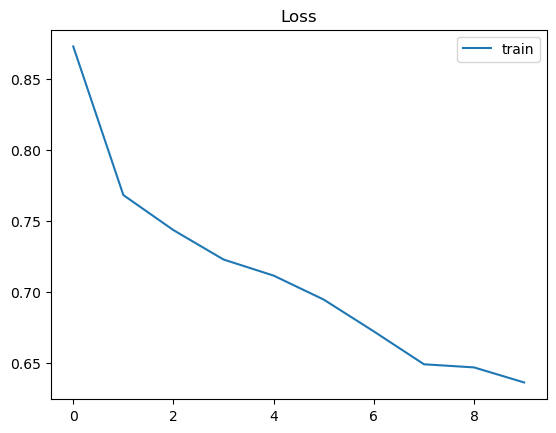

In [74]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show();

In [80]:
# model evaluation
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
accuracy

0.7090761661529541

In [79]:
from sklearn.metrics import f1_score
# Predict classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Compute F1 Score
y_true_classes = np.argmax(Y_test, axis=1)  # Convert one-hot encoded true labels to class labels
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')  # Compute F1 score
f1

39/39 [==============================] - 1s 13ms/step


0.6948461305475885